In [4]:
!pip install adversarial-robustness-toolbox

### Function to plot confusion matrix

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report

def plot_confusion_matrix(model, x_test_onehot, y_test_onehot):
    # Make predictions on the test set

    y_test_labels=np.argmax(y_test_onehot, axis=1)

    y_pred_labels = np.argmax(model.predict(x_test_onehot), axis=1)

    # Generate confusion matrix
    conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
    
    # Define labels for the plot
    labels = [str(i) for i in range(10)]

    # Create heatmap using seaborn
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    print(classification_report(y_test_labels, y_pred_labels))
    # Show plot
    plt.show()


## Vanilla model

In [6]:
# -*- coding: utf-8 -*-
"""Trains a convolutional neural network on the MNIST dataset, then attacks it with the FGSM attack."""
from __future__ import absolute_import, division, print_function, unicode_literals

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

tf.compat.v1.disable_eager_execution()

# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("mnist"))

# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

# Evaluate the classifier on the test set
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))



Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 19s 320us/sample - loss: 0.2429 - accuracy: 0.9266
Epoch 2/5
60000/60000 [==============================] - 19s 322us/sample - loss: 0.0889 - accuracy: 0.9735
Epoch 3/5
60000/60000 [==============================] - 19s 318us/sample - loss: 0.0670 - accuracy: 0.9798
Epoch 4/5
60000/60000 [==============================] - 19s 323us/sample - loss: 0.0518 - accuracy: 0.9836
Epoch 5/5
60000/60000 [==============================] - 20s 327us/sample - loss: 0.0481 - accuracy: 0.9851

Test accuracy: 98.91%


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



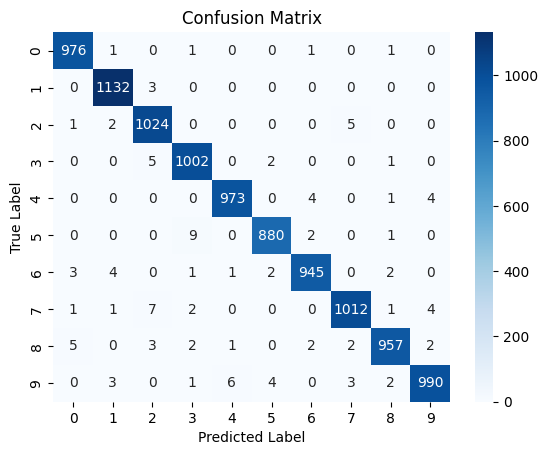

In [31]:
plot_confusion_matrix(classifier, x_test, y_test)

# FGSM

## Testing FGSM samples

In [49]:
# Craft adversarial samples with FGSM
epsilon = 0.2  # Maximum perturbation
adv_crafter_fgsm = FastGradientMethod(classifier, eps=epsilon)
x_test_adv_fgsm = adv_crafter_fgsm.generate(x=x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(classifier.predict(x_test_adv_fgsm), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))


Test accuracy on adversarial sample: 55.71%


### Plotting FGSM attack samples

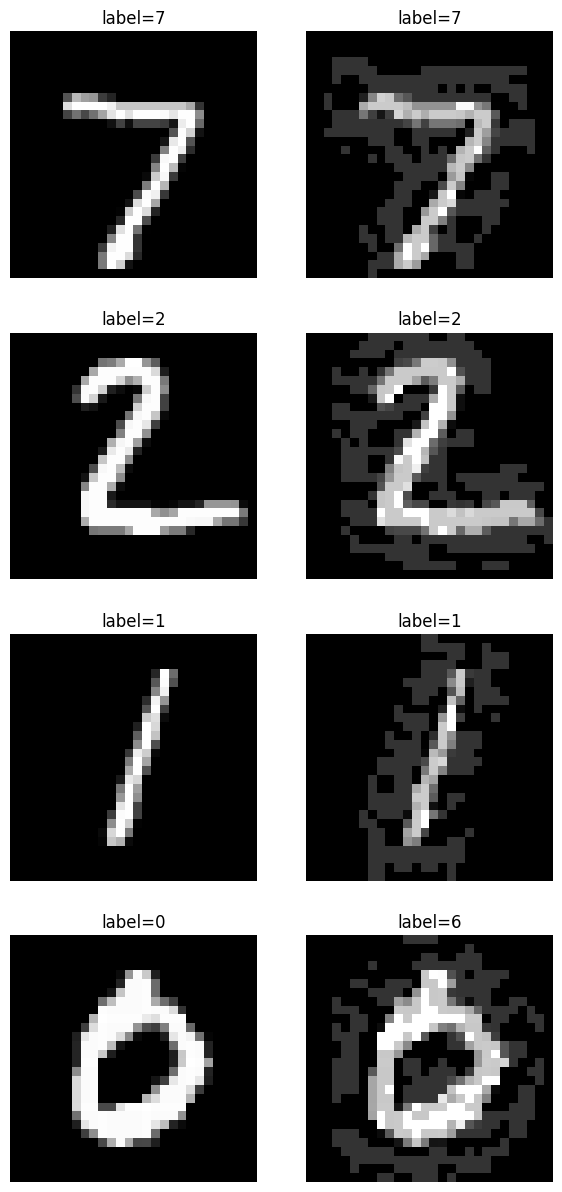

In [45]:


import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7,15))

for i in range (0,4):
    img_here=x_test[i]
    img_here_label=y_test[i]
    fgsm_gen = FastGradientMethod(classifier, eps=.2)
    cf_image=fgsm_gen.generate(img_here.reshape(1,28,28,1))
    label_here=np.argmax(classifier.predict(cf_image.reshape(1,28,28,1)))
    axes[i,0].imshow(img_here.reshape(28,28,1),cmap='gray')
    axes[i,0].set_title(f'label={np.argmax(img_here_label)}')
    axes[i,1].imshow(cf_image.reshape(28,28,1),cmap='gray')
    axes[i,1].set_title(f'label={label_here}')

for ax in axes.flatten():
    ax.axis('off')

# Show the plot
plt.show()


## Adversarial Training - Training FGSM on combined samples 

In [46]:
# generating adversarial train examples
x_train_adv_fgsm = adv_crafter_fgsm.generate(x=x_train)

#combining adv train and test data
x_combined_train_fgsm = np.concatenate([x_train, x_train_adv_fgsm])
x_combined_test_fgsm = np.concatenate([x_test, x_test_adv_fgsm])
y_combined_train_fgsm = np.concatenate([y_train,y_train])


In [47]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

classifier_adv_fgsm = KerasClassifier(model=model, clip_values=(min_, max_))
classifier_adv_fgsm.fit(x_combined_train_fgsm, y_combined_train_fgsm, nb_epochs=5, batch_size=128)

# Evaluate the classifier on the test set
preds_adv_fgsm = np.argmax(classifier_adv_fgsm.predict(x_test_adv_fgsm), axis=1)
acc_fgsm = np.sum(preds_adv_fgsm == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc_fgsm * 100))

Train on 120000 samples
Epoch 1/5
120000/120000 [==============================] - 39s 321us/sample - loss: 0.0755 - accuracy: 0.9758
Epoch 2/5
120000/120000 [==============================] - 38s 321us/sample - loss: 0.0359 - accuracy: 0.9891
Epoch 3/5
120000/120000 [==============================] - 39s 327us/sample - loss: 0.0272 - accuracy: 0.9915
Epoch 4/5
120000/120000 [==============================] - 39s 327us/sample - loss: 0.0231 - accuracy: 0.9927
Epoch 5/5
120000/120000 [==============================] - 40s 334us/sample - loss: 0.0200 - accuracy: 0.9937


c:\Users\mvarghese\.conda\envs\pytorch\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Test accuracy: 99.06%


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



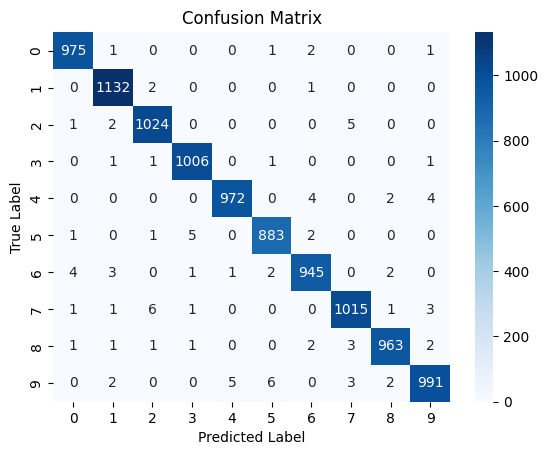

In [48]:
plot_confusion_matrix(classifier_adv_fgsm, x_test_adv_fgsm, y_test)


# PGD

## Testing PGD samples

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from __future__ import absolute_import, division, print_function, unicode_literals

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np

from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

import tensorflow.compat.v1 as tf

In [61]:

# Craft adversarial samples with PGD
epsilon = 0.1  # Maximum perturbation
adv_crafter = ProjectedGradientDescent(classifier, norm=np.inf, eps=0.2, eps_step=0.05, verbose=False)
x_test_adv = adv_crafter.generate(x=x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))


Test accuracy on adversarial sample: 0.58%


### Plotting PGD attack samples

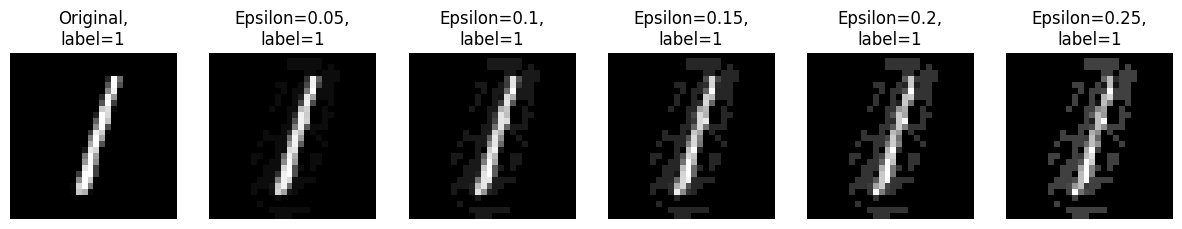

<Figure size 1500x1500 with 0 Axes>

In [62]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("mnist"))

# Generate some random image data
gen_image=[]
epsilon_list=[.05,.1,.15,.2,.25]
gen_image.append(x_test[2])
result=[]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
plt.figure(figsize=(15,15))
axes[0].imshow(gen_image[0],cmap='gray')
axes[0].set_title(f'Original,\nlabel={1}')


for i in range (1,6):
    cftr = FastGradientMethod(classifier, eps=epsilon_list[i-1])
    cf_image = cftr.generate(x=gen_image[0].reshape(1,28,28, 1))
    label_here=np.argmax(classifier.predict(cf_image))

    gen_image.append( cf_image.reshape(28,28,1))
    

    axes[i].imshow(gen_image[i],cmap='gray')
    axes[i].set_title(f'Epsilon={epsilon_list[i-1]},\nlabel={label_here}')

for ax in axes.flatten():
    ax.axis('off')

# Show the plot
plt.show()


              precision    recall  f1-score   support

           0       0.01      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.01      0.01      0.01       982
           5       0.00      0.01      0.01       892
           6       0.01      0.01      0.01       958
           7       0.01      0.01      0.01      1028
           8       0.00      0.00      0.00       974
           9       0.01      0.01      0.01      1009

    accuracy                           0.01     10000
   macro avg       0.01      0.01      0.01     10000
weighted avg       0.01      0.01      0.01     10000



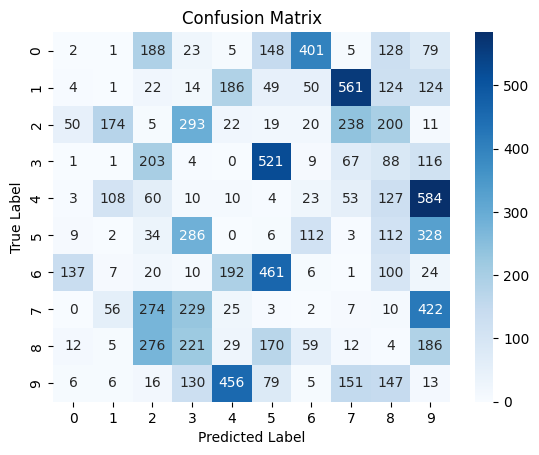

In [63]:
plot_confusion_matrix(classifier, x_test_adv, y_test)


## Adversarial Training - Training PGD on combined samples 

In [64]:
# generating adversarial train examples
x_train_adv = adv_crafter.generate(x=x_train)

#combining adv train and test data
x_combined_train = np.concatenate([x_train, x_train_adv])
x_combined_test = np.concatenate([x_test, x_test_adv])
y_combined_train = np.concatenate([y_train,y_train])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

classifier_adv_pgd = KerasClassifier(model=model, clip_values=(min_, max_))
classifier_adv_pgd.fit(x_combined_train, y_combined_train, nb_epochs=5, batch_size=128)

# Evaluate the classifier on the test set
preds_adv = np.argmax(classifier_adv_pgd.predict(x_test_adv), axis=1)
acc = np.sum(preds_adv == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))

Train on 120000 samples
Epoch 1/5
120000/120000 [==============================] - 41s 338us/sample - loss: 0.2124 - accuracy: 0.9621
Epoch 2/5
120000/120000 [==============================] - 41s 339us/sample - loss: 0.0232 - accuracy: 0.9927
Epoch 3/5
120000/120000 [==============================] - 40s 337us/sample - loss: 0.0189 - accuracy: 0.9941
Epoch 4/5
120000/120000 [==============================] - 40s 337us/sample - loss: 0.0178 - accuracy: 0.9945
Epoch 5/5
120000/120000 [==============================] - 40s 337us/sample - loss: 0.0160 - accuracy: 0.9948


c:\Users\mvarghese\.conda\envs\pytorch\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Test accuracy: 99.22%


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



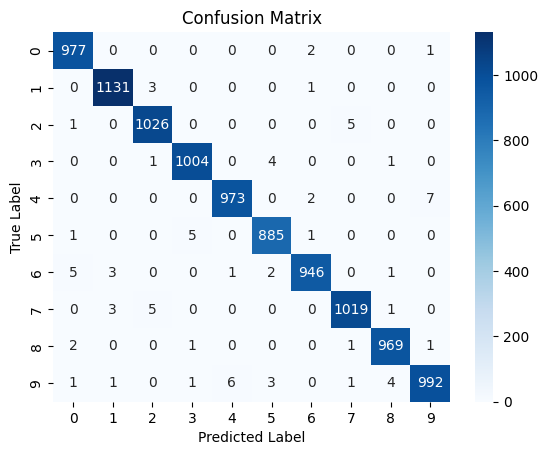

In [65]:
plot_confusion_matrix(classifier_adv_pgd, x_test_adv, y_test)

# Deepfool - Training on Vanilla model

In [70]:
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()

import tensorflow_addons as tfa

from art.attacks.evasion import DeepFool
from art.estimators.classification import KerasClassifier, TensorFlowClassifier
from art.utils import load_mnist


In [72]:
# -*- coding: utf-8 -*-
"""Trains a CNN on the MNIST dataset using the Keras backend, then generates adversarial images using DeepFool
and uses them to attack a CNN trained on MNIST using TensorFlow. This is to show how to perform a
black-box attack: the attack never has access to the parameters of the TensorFlow model.
"""

def cnn_mnist_tf(input_shape):
    labels_tf = tf.placeholder(tf.float32, [None, 10])
    inputs_tf = tf.placeholder(tf.float32, [None] + list(input_shape))

    # Define the TensorFlow graph
    conv = tf.layers.conv2d(inputs_tf, 4, 5, activation=tf.nn.relu)
    conv = tf.layers.max_pooling2d(conv, 2, 2)
    fc = tf.layers.flatten(conv)

    # Logits layer
    logits = tf.layers.dense(fc, 10)

    # Train operator
    loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels_tf))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_tf = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    classifier = TensorFlowClassifier(
        clip_values=(0, 1), input_ph=inputs_tf, output=logits, loss=loss, train=train_tf, labels_ph=labels_tf, sess=sess
    )
    return classifier


def cnn_mnist_k(input_shape):
    # Create simple CNN
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(5, 5), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
    )

    classifier = KerasClassifier(model=model, clip_values=(0, 1))
    return classifier


# Get session
session = tf.Session()
k.set_session(session)

# Read MNIST dataset
(x_train_df, y_train_df), (x_test_df, y_test_df), min_, max_ = load_mnist()

# Construct and train a convolutional neural network on MNIST using Keras
source = cnn_mnist_k(x_train_df.shape[1:])
source.fit(x_train_df, y_train_df, nb_epochs=5, batch_size=128)



Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 35us/sample - loss: 0.2178 - acc: 0.9349
Epoch 2/5
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0950 - acc: 0.9708
Epoch 3/5
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0805 - acc: 0.9749
Epoch 4/5
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0717 - acc: 0.9777
Epoch 5/5
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0686 - acc: 0.9781


In [73]:
# Evaluate the CNN on the adversarial samples
preds_df = source.predict(x_test)
acc_df = np.sum(np.equal(np.argmax(preds_df, axis=1), np.argmax(y_test, axis=1))) / y_test.shape[0]
print("\nAccuracy on test data (Vanilla Accuracy): %.2f%%" % (acc_df * 100))


Accuracy on adversarial samples: 97.57%


## Testing Deepfool Samples

In [75]:
# Craft adversarial samples with DeepFool
adv_crafter_df = DeepFool(source)
x_train_adv_df = adv_crafter_df.generate(x_train_df)
x_test_adv_df = adv_crafter_df.generate(x_test_df)

DeepFool: 100%|██████████| 10000/10000 [00:50<00:00, 196.64it/s]


In [77]:
# Evaluate the CNN on the adversarial samples
preds_df = source.predict(x_test_adv_df)
acc_df = np.sum(np.equal(np.argmax(preds_df, axis=1), np.argmax(y_test_df, axis=1))) / y_test_df.shape[0]
print("\nAccuracy on adversarial samples: %.2f%%" % (acc_df * 100))


Accuracy on adversarial samples: 6.43%


              precision    recall  f1-score   support

           0       0.02      0.01      0.01       980
           1       0.20      0.11      0.15      1135
           2       0.05      0.10      0.06      1032
           3       0.05      0.06      0.06      1010
           4       0.07      0.07      0.07       982
           5       0.09      0.07      0.08       892
           6       0.18      0.06      0.09       958
           7       0.05      0.05      0.05      1028
           8       0.03      0.06      0.04       974
           9       0.14      0.04      0.06      1009

    accuracy                           0.06     10000
   macro avg       0.09      0.06      0.07     10000
weighted avg       0.09      0.06      0.07     10000



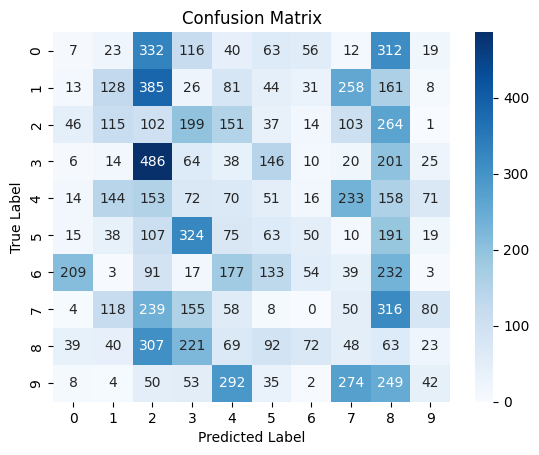

In [78]:
plot_confusion_matrix(source, x_test_adv_df, y_test)

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


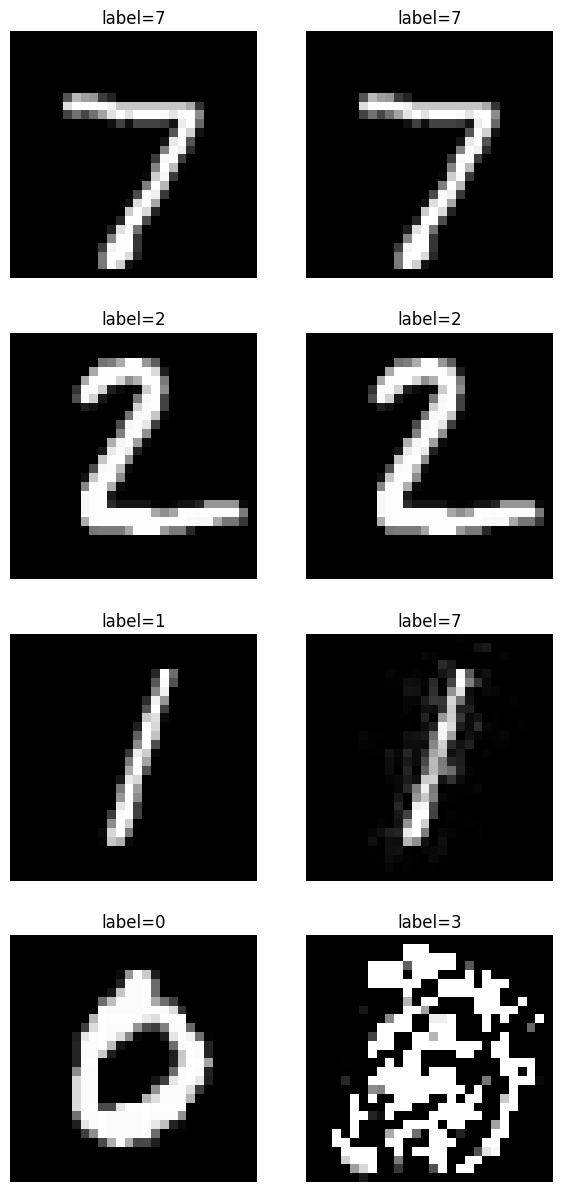

In [86]:
import matplotlib.pyplot as plt
import numpy as np


(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("mnist"))

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7,15))

for i in range (0,4):
    img_here=x_test[i]
    img_here_label=y_test[i]
    clfs = DeepFool(source,nb_grads=3)
    cf_image=clfs.generate(img_here.reshape(1,28,28,1))
    label_here=np.argmax(source.predict(cf_image.reshape(1,28,28,1)))
    axes[i,0].imshow(img_here.reshape(28,28,1),cmap='gray')
    axes[i,0].set_title(f'label={np.argmax(img_here_label)}')
    axes[i,1].imshow(cf_image.reshape(28,28,1),cmap='gray')
    axes[i,1].set_title(f'label={label_here}')

for ax in axes.flatten():
    ax.axis('off')

# Show the plot
plt.show()


## Adversarial Training - Training Deepfool on combined samples 

In [87]:
#combining adv train and test data
x_combined_train_df = np.concatenate([x_train_df, x_train_adv_df])
x_combined_test_df = np.concatenate([x_test_df, x_test_adv_df])
y_combined_train_df = np.concatenate([y_train_df,y_train_df])

# Construct and train a convolutional neural network
target = cnn_mnist_tf(x_combined_train_df.shape[1:])
target.fit(x_combined_train_df, y_combined_train_df, nb_epochs=5, batch_size=128)



C:\Users\mvarghese\AppData\Local\Temp\ipykernel_52912\267309169.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(inputs_tf, 4, 5, activation=tf.nn.relu)
C:\Users\mvarghese\AppData\Local\Temp\ipykernel_52912\267309169.py:13: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  conv = tf.layers.max_pooling2d(conv, 2, 2)
C:\Users\mvarghese\AppData\Local\Temp\ipykernel_52912\267309169.py:14: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  fc = tf.layers.flatten(conv)
C:\Users\mvarghese\AppData\Local\Temp\ipykernel_52912\267309169.py:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(fc, 10

In [88]:
# Evaluate the classifier on the test set
preds_adv_df = np.argmax(target.predict(x_test_adv_df), axis=1)
acc_adv_df = np.sum(preds_adv_df == np.argmax(y_test_df, axis=1)) / y_test_df.shape[0]
print("\nTest accuracy: %.2f%%" % (acc_adv_df * 100))


Test accuracy: 95.54%


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.97      0.97      0.97      1135
           2       0.95      0.94      0.95      1032
           3       0.97      0.95      0.96      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.94      0.95       892
           6       0.97      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.87      0.96      0.91       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



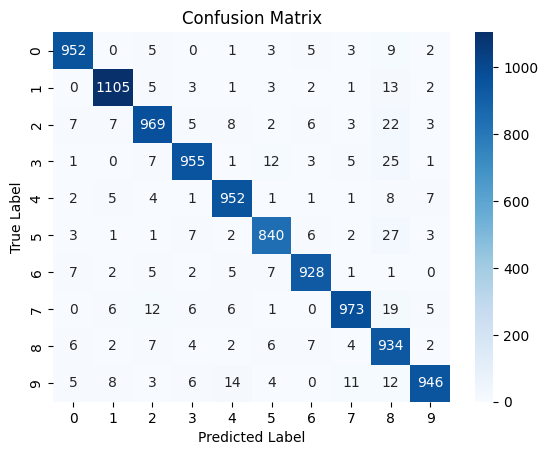

In [89]:
plot_confusion_matrix(target, x_test_adv_df, y_test)

## Leave this, just plain trials for using the ART library to find more evaluation metrics, this will only work with FGSM as other attacks are not supported, we need to find other ways of calculating the robustness understanding the code they use 

reference : https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/metrics/metrics.py

In [90]:
# import numpy as np
# import matplotlib.pyplot as plt
# from art.metrics.metrics import empirical_robustness

# # Evaluate the neural network
# #loss, acc = model.evaluate(x_test_adv, y_test)

# # Compute robustness and average Lp distance
# robustness = empirical_robustness(target, x_test, x_test_adv_df)
# #robustness = rv.robustness()
# avg_lp_distance = robustness.avg_lp_distance(p=2)

# # Visualize results
# plt.bar(['Accuracy', 'Robustness', 'Avg L2 Distance'], [acc_adv_df, robustness, avg_lp_distance])
# plt.title('Neural Network Evaluation Metrics')
# plt.show()

# Next steps :

1. Consult the earlier notebook to plot visualizations for the corrupted inputs after perturbations, alternate way is to use the visualizations from the ART library used above, but it will take some time to figure out their method.

2. Plot graph for the loss and accuracy for only adversarial vs adversarial training 

3. Include more metrics of evaluation like F1 score, AUC etc
